In [47]:
import numpy as np 
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

%matplotlib inline
np.set_printoptions(suppress=True)

### Download the data

In [48]:
!curl -L -o ./data/20news_home/20news-bydate.tar.gz http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz
!mkdir -p ./data/20news_home/
!tar xzf ./data/20news_home/20news-bydate.tar.gz -C ./data/20news_home/


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to open the file ./data/20news_home/20news-bydate.tar.gz: No such file or directory

  0 13.7M    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (23) client returned ERROR on write of 14274 bytes
tar: Error opening archive: Failed to open './data/20news_home/20news-bydate.tar.gz'


### Explore the data

In [49]:
categories = ["alt.atheism", "talk.religion.misc", "comp.graphics", "sci.space"]
remove = ("headers", "footers", "quotes")
newsgroups_train = fetch_20newsgroups(
    data_home="./data",
    subset="train",
    categories=categories,
    remove=remove,
)
newsgroup_test = fetch_20newsgroups(
    data_home="./data",
    subset="test",
    categories=categories,
    remove=remove,
)

print(newsgroups_train.filenames.shape, newsgroups_train.target.shape)

(2034,) (2034,)


In [50]:
print(np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]])
print(newsgroups_train.target[:10])

['comp.graphics' 'talk.religion.misc' 'sci.space']
[1 3 2 0 2 0 2 1 2 1]


### Stop words, stemming, lemmatization

#### stop words 停用詞

From [Intro to Information Retrieval](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html):

一些極為常見的詞語，對於幫助選擇符合使用者需求的文件似乎幾乎沒有價值，因此會完全從詞彙表中排除掉。這些詞語被稱為停用詞（stop words）。

隨著時間的推移，資訊檢索系統的普遍趨勢是從使用相當大的停用詞列表（200-300個詞）到非常小的停用詞列表（7-12個詞），再到完全不使用停用詞列表。網路搜尋引擎通常不使用停用詞列表。

In [51]:
import nltk
from nltk.corpus import stopwords

print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

#### Stemming and Lemmatization

from [Information Retrieval](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) textbook:

詞幹提取（Stemming）和詞形還原（Lemmatization）都會生成詞語的根形式。

詞形還原依據語言的規則，生成的詞彙都是實際存在的詞。

"Stemming is the poor-man’s lemmatization." (Noah Smith, 2011)

詞幹提取是一種粗略的啟發式方法，它會直接截掉詞語的結尾。生成的詞彙可能並不是實際存在的詞，但詞幹提取的速度更快。

In [52]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [53]:
from nltk import stem

wnl = stem.WordNetLemmatizer()
porter = stem.porter.PorterStemmer()

word_list = ["feet", "foot", "foots", "footing"]
print([wnl.lemmatize(word) for word in word_list])
print([porter.stem(word) for word in word_list])

['foot', 'foot', 'foot', 'footing']
['feet', 'foot', 'foot', 'foot']


詞幹提取和詞形還原依賴於語言。具有更複雜詞法結構的語言可能會展現出更大的效益。

## Spacy

詞幹提取和詞形還原取決於實作方式。

Spacy 是一個非常現代且快速的自然語言處理（NLP）庫。Spacy 的設計具有明確的取向，通常提供一種高度優化的方式來完成某些任務（相比之下，nltk 提供了多種方式，儘管通常不如 Spacy 優化）。

pip install -U spacy

接著，你需要下載英文模型：
spacy -m download en_core_web_sm

In [54]:
!spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.8 MB 3.4 MB/s eta 0:00:04
     ------------ --------------------------- 3.9/12.8 MB 9.8 MB/s eta 0:00:01
     ----------------------- ---------------- 7.6/12.8 MB 12.7 MB/s eta 0:00:01
     ----------------------------------- ---- 11.3/12.8 MB 13.8 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 12.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [55]:
import spacy


nlp = spacy.load("en_core_web_sm")
print(sorted(list(nlp.Defaults.stop_words))[:20])

["'d", "'ll", "'m", "'re", "'s", "'ve", 'a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also']


這些方法長期以來被認為是標準技術，但在使用深度學習時，它們往往會降低效能。詞幹提取、詞形還原以及移除停用詞都涉及丟棄資訊。

然而，在處理較簡單的模型時，它們仍然可能有用。

Another approach: sub-word units

[SentencePiece](https://github.com/google/sentencepiece) library from Google

### Data Processing

接下來，scikit-learn 提供了一個方法，可以為我們提取所有的詞頻計數。

我們將學習如何編寫自己的 CountVectorizer，來了解其背後的運作原理。

In [56]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

In [57]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [58]:
vocab = np.array(vectorizer.get_feature_names_out())
print(vocab.shape)
print(vocab[7000:7020])

(26576,)
['cosmonauts' 'cosmos' 'cosponsored' 'cost' 'costa' 'costar' 'costing'
 'costly' 'costruction' 'costs' 'cosy' 'cote' 'couched' 'couldn' 'council'
 'councils' 'counsel' 'counselees' 'counselor' 'count']


### Singular Value Decomposition (SVD)


"SVD is not nearly as famous as it should be." - Gilbert Strang

我們可以明顯地預期，在一個主題中最常出現的詞語在另一個主題中會較少出現——否則，這些詞語就無法很好地區分這兩個主題。因此，我們預期這些主題是正交的。

SVD 演算法將一個矩陣分解為一個具有正交列的矩陣和一個具有正交列的矩陣（以及一個包含每個因子相對重要性的對角矩陣）。

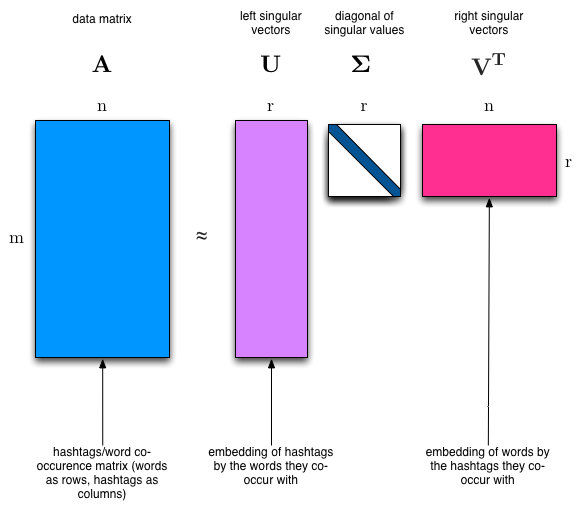
source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/)

SVD 是一種精確的分解方法，因為它生成的矩陣足夠大，可以完全覆蓋原始矩陣。SVD 在線性代數中被廣泛使用，特別是在資料科學中，包括以下應用：
* 語意分析
* 協同過濾/推薦系統（例如 Netflix Prize 的獲勝方案）
* 計算 Moore-Penrose 廣義逆矩陣
* 資料壓縮
* 主成分分析
  
潛在語意分析（LSA）使用了 SVD。有時候，你會聽到主題建模被稱為 LSA。

In [59]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: total: 1min 5s
Wall time: 16.4 s


In [60]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


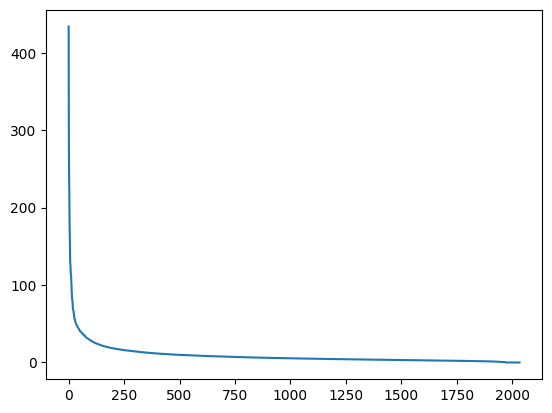

In [61]:
# show the singular values s
import matplotlib.pyplot as plt
plt.plot(s)

plt.show()

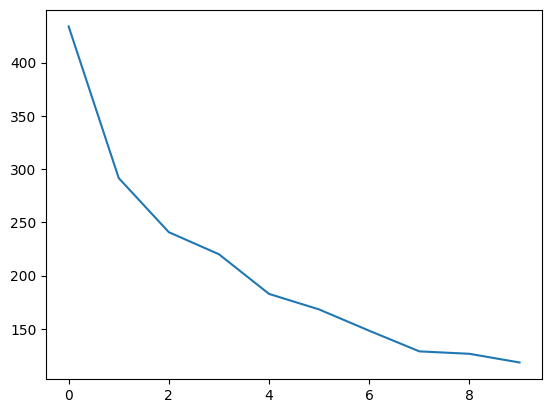

In [62]:
plt.plot(s[:10])
plt.show()

In [63]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

show_topics(Vh[:10])

['critus ditto propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

我們得到的主題與我們預期的群集類型相符！這儘管是一種無監督的演算法——也就是說，我們從未實際告訴演算法我們的文件是如何分組的。

我們稍後會更詳細地探討 SVD。目前，重要的結論是，我們有一個工具(SVD)可以將矩陣精確分解為正交的列和正交的行。

### Non-negative Matrix Factorization (NMF)

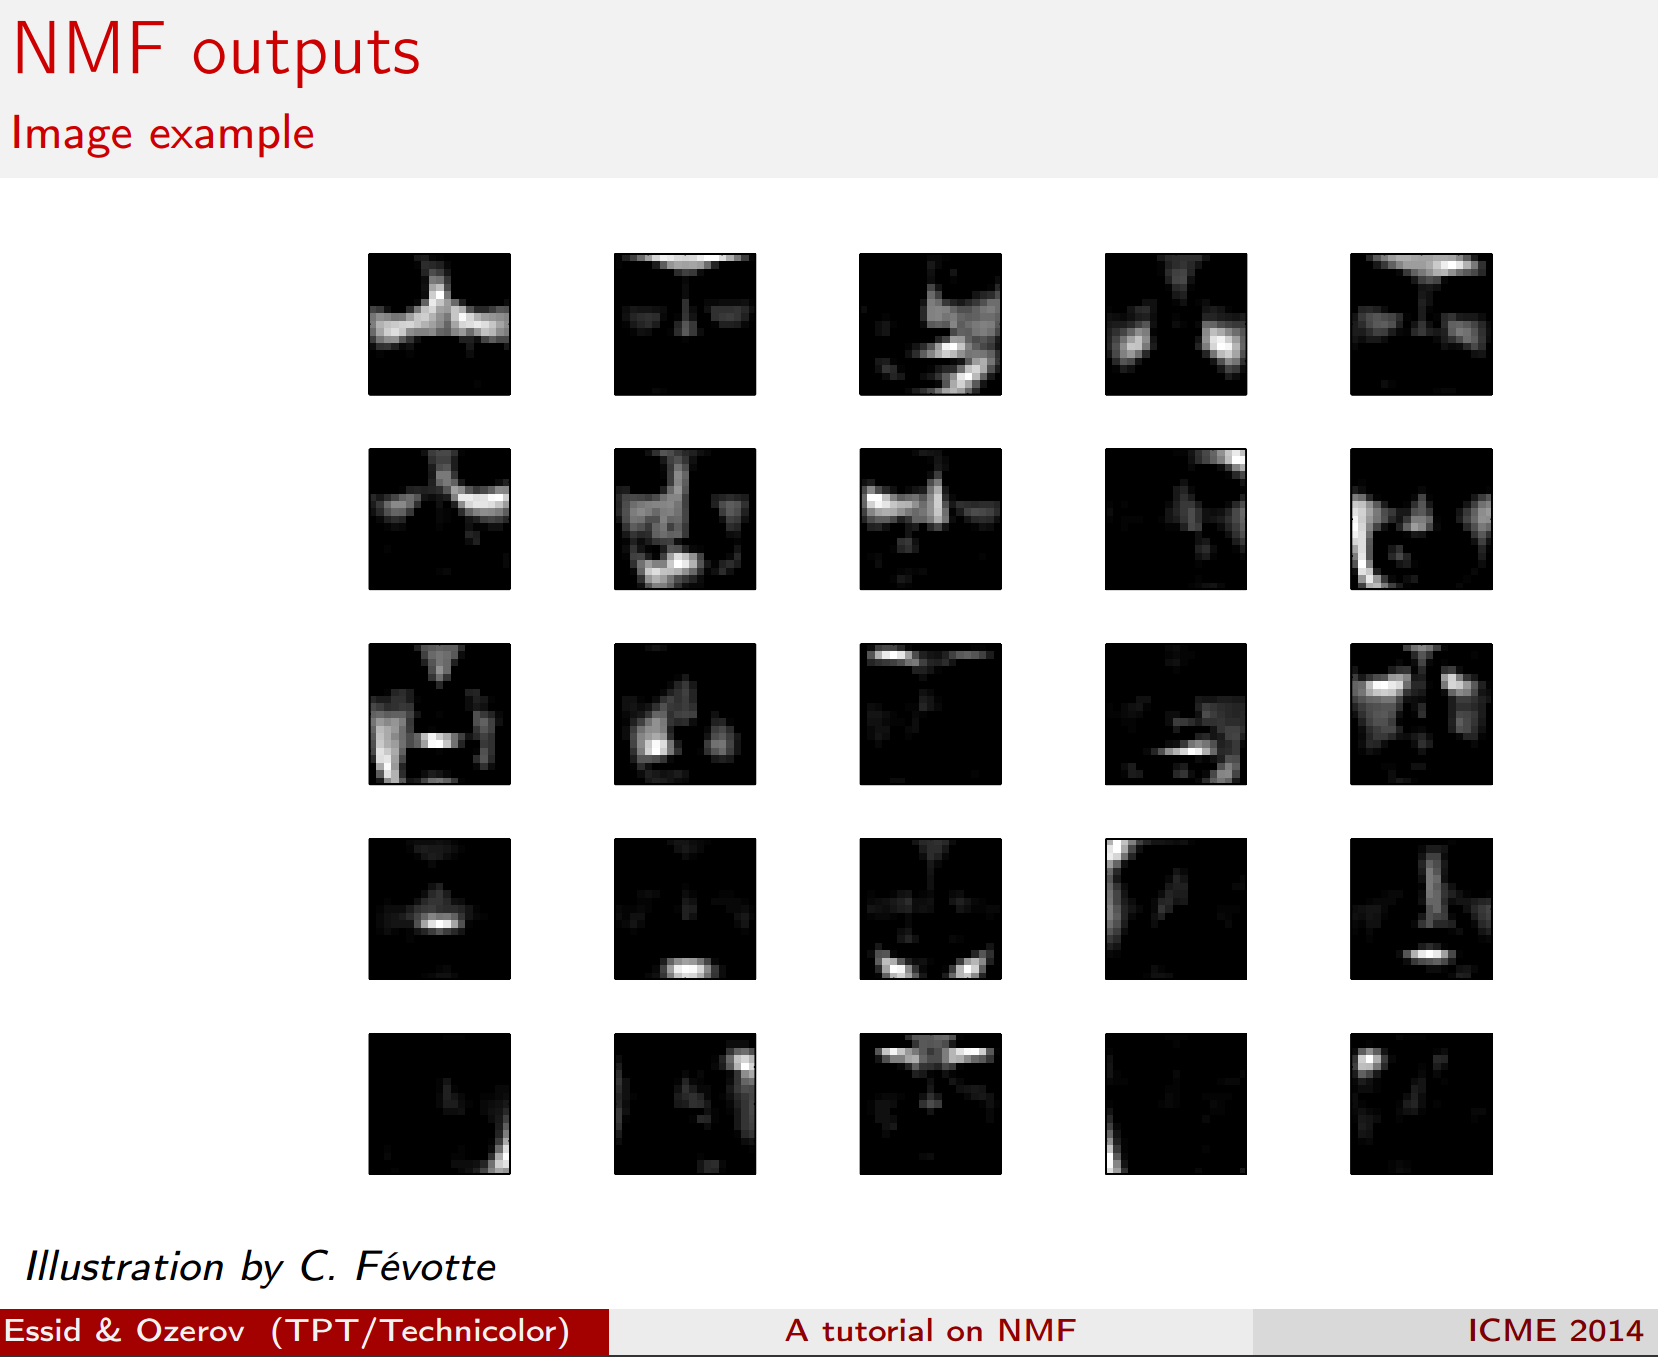
source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf)

Idea

與其將我們的因子限制為正交，另一個想法是將它們限制為非負值。NMF 是對非負資料集 VV 的分解：

$$VV = WH$$

分解為非負矩陣 $W$, $H$。通常，正值因子會更容易解釋（這也是 NMF 受歡迎的原因）。

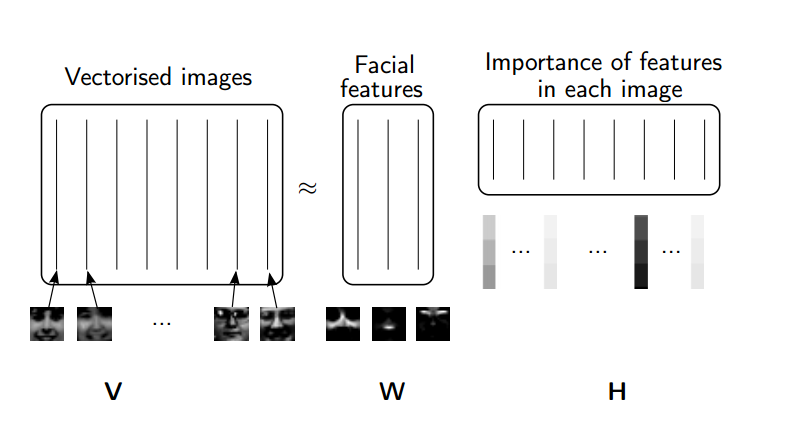
source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf)

非負矩陣分解（NMF）是一種非精確的分解方法，將矩陣分解為一個瘦長的正矩陣和一個短小的正矩陣。NMF 是 NP 困難且非唯一的。針對 NMF，有許多變體是透過添加不同的限制條件而產生的。

Applications of NMF
* [Face Decompositions](http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py)
* [Collaborative Filtering, eg movie recommendations](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/)
* [Audio source separation](https://pdfs.semanticscholar.org/cc88/0b24791349df39c5d9b8c352911a0417df34.pdf)
* [Chemistry](http://ieeexplore.ieee.org/document/1532909/)
* [Bioinformatics](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-015-0485-4) and [Gene Expression](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2623306/)
* Topic Modeling

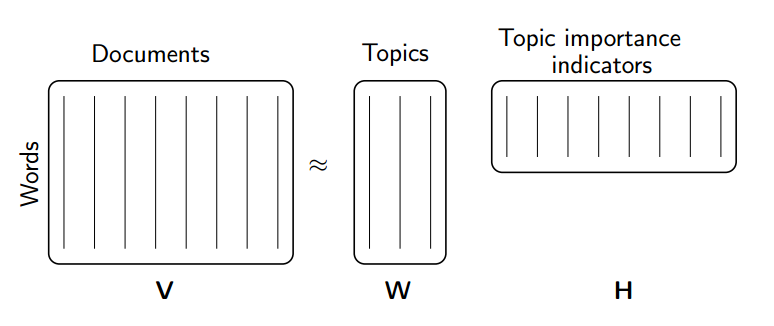

More Reading:
* [The Why and How of Nonnegative Matrix Factorization](https://arxiv.org/pdf/1401.5226.pdf)

In [64]:
# NMF from sklearn

m, n = vectors.shape
d = 5  # num topics

clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(np.asarray(vectors))
H1 = clf.components_

show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

### TF-IDF

[Topic Frequency-Inverse Document Frequency](http://www.tfidf.com/) (TF-IDF)是一種透過考量詞彙在文件中出現的頻率、文件的長度，以及詞彙的常見或罕見程度來正規化詞彙計數的方法。

* TF = (# occurrences of term t in document) / (# of words in documents)
* IDF = log(# of documents / # documents with term t in it)

In [65]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [66]:
newsgroups_train.data[10:20]

["a\n\nWhat about positional uncertainties in S-L 1993e?   I assume we know where\nand what Galileo is doing within a few meters.   But without the\nHGA,  don't we have to have some pretty good ideas, of where to look\nbefore imaging?  If the HGA was working,  they could slew around\nin near real time (Less speed of light delay).  But when they were\nimaging toutatis????  didn't someone have to get lucky on a guess to\nfind the first images?   \n\nAlso, I imagine S-L 1993e will be mostly a visual image.  so how will\nthat affect the other imaging missions.  with the LGA,  there is a real\ntight allocation of bandwidth.   It may be premature to hope for answers,\nbut I thought i'd throw it on the floor.",
 "I would like to program Tseng ET4000 to nonstandard 1024x768 mode by\nswitching to standard 1024x768 mode using BIOS and than changing some\ntiming details (0x3D4 registers 0x00-0x1F) but I don't know how to\nselect 36 MHz pixel clock I need. The BIOS function selects 40 MHz.\n\nIs t

In [67]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [68]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

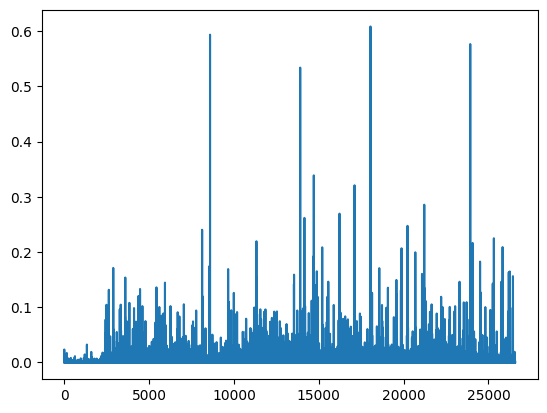

In [69]:
plt.plot(clf.components_[0])
plt.show()

In [70]:
clf.reconstruction_err_

43.71292606348688

NMF 總結

優點：快速且易於使用！

缺點：花費多年研究與專業知識才得以實現

注意事項：
* 對於 NMF，矩陣的行數必須至少與列數相等，否則在執行 fit_transform 時會出現錯誤
* 可以在 CountVectorizer 中使用 df_min，只關注至少出現在 k 個分割文本中的詞彙

### Truncated SVD

當我們只計算感興趣的部分列時，使用 NMF 節省了大量時間。有沒有辦法在 SVD 中也能獲得這種好處呢？當然有！這稱為 truncated SVD。

我們只需要關注與最大奇異值對應的向量即可。

傳統分解演算法的缺點：
* 矩陣「大得驚人」
* 數據經常缺失或不準確。如果輸入數據的精確度已經限制了輸出的精確度，為何還要花費額外的計算資源？
* 數據傳輸現在在演算法的運行時間中扮演了重要角色。即使需要更多浮點運算（flops = 浮點運算次數），但如果技術能減少對數據的多次遍歷，可能會大幅提高速度。
* 善用 GPU 是非常重要的。

隨機化演算法的優點：
* 本身非常穩定，不容易受到影響。
* 性能表現穩定，不會依賴於數據中複雜的數學特性。
* 所需的矩陣與向量運算可以同時進行，大幅提升效率。

In [73]:
from sklearn import decomposition
%time u, s, v = decomposition.randomized_svd(vectors, 10)

CPU times: total: 11.6 s
Wall time: 7.84 s


In [74]:
import fbpca
%time u, s, v = fbpca.pca(vectors, 10)

CPU times: total: 1.69 s
Wall time: 987 ms


* For more on randomized SVD, check out my PyBay 2017 talk.
* For significantly more on randomized SVD, check out the Computational Linear Algebra course.